In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.chdir('../../')
os.getcwd()

'/home/bunny/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import sys
import numpy as np
from tqdm import tqdm

In [6]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB16 as SCB
from omegaconf import OmegaConf as ocf

In [7]:
dataset_name = 'iemocap'
experiment_prefix = "scb16"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run0/'
data_dir = "../data/data_preprocessed/"
dataset_config_path = f'config/dataset/{dataset_name}4.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
batch_size = 2

{'name': 'iemocap', 'dataset_class': 'WaveformDataset', 'root': 'iemocap/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label4', 'feature_name': 'audio16k', 'num_classes': 4, 'label_values': ['neu', 'hap', 'sad', 'ang'], 'classnames': ['neu', 'hap', 'sad', 'ang'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [8]:
in_channels = 1
out_channels = 8
embedding_dim = 1023
num_embeddings = 384
commitment_cost = 0.25
learning_rate = 1e-4
num_tokens = 256
num_classes = 4

In [9]:
iconnet_config_path = f'config/model/m19win.yaml'
iconnet_config = ocf.load(iconnet_config_path)
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [256], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [10]:
codebook_pretrained_path = f'../scb7_models/iemocap/codebook.epoch=76.pt'
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [11]:
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)

In [12]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=1, loss_cls=1)
trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=4)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [13]:
trainer.setup(model=model, lr=learning_rate)

In [14]:
trainer.fit(n_epoch=50, self_supervised=False, train_task='embedding', test_n_epoch=10)

  1%|▍                                                   | 0.476833976833989/50 [07:26<390:25:33, 28381.33s/it]

Epoch: 1	Loss: 1.277 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.277]	Val_acc: 96/197 (48.73%)

Saved new best val model: ../scb16_models/iemocap/run0/model.epoch=1.step=741.loss=1.277.val_acc=0.487.pt


  3%|█▌                                                     | 1.4295366795367364/50 [19:28<9:05:47, 674.22s/it]

Correct: 434/988 (0.4393)
Saved new best test model: ../scb16_models/iemocap/run0/model.epoch=1.step=1480.test_acc=0.4393.pt
{'acc_unweighted': tensor(0.4180, device='cuda:0'),
 'acc_weighted': tensor(0.4393, device='cuda:0'),
 'f1s_unweighted': tensor(0.3610, device='cuda:0'),
 'f1s_weighted': tensor(0.3739, device='cuda:0'),
 'rocauc': tensor(0.7427, device='cuda:0'),
 'uar': tensor(0.4180, device='cuda:0'),
 'wap': tensor(0.3833, device='cuda:0')}
{'acc_detail': tensor([0.2579, 0.5614, 0.8525, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.3713, 0.4369, 0.6357, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.6628, 0.3575, 0.5068, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.2579, 0.5614, 0.8525, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.8002, 0.5758, 0.8761, 0.7188], device='cuda:0')}
tensor([[ 57, 145,  19,   0],
        [  3, 192, 147,   0],
        [  0,  32, 185,   0],
        [ 26, 168,  14,   0]], device='cuda:0')


  4%|█▉                                                 | 1.9063706563707945/50 [26:57<381:44:00, 28574.27s/it]

Epoch: 2	Loss: 0.751 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.751]	Val_acc: 86/197 (43.65%)



  6%|██▉                                                | 2.8590733590736597/50 [41:13<370:21:59, 28283.70s/it]

Epoch: 3	Loss: 1.042 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.042]	Val_acc: 96/197 (48.73%)



  8%|███▉                                                | 3.811776061776525/50 [55:28<367:15:05, 28624.29s/it]

Epoch: 4	Loss: 1.700 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.700]	Val_acc: 109/197 (55.33%)

Saved new best val model: ../scb16_models/iemocap/run0/model.epoch=4.step=5181.loss=1.700.val_acc=0.553.pt


 10%|████▊                                              | 4.76447876447939/50 [1:09:43<356:18:02, 28355.64s/it]

Epoch: 5	Loss: 0.903 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.903]	Val_acc: 102/197 (51.78%)



 11%|█████▋                                            | 5.717181467182255/50 [1:24:01<356:12:36, 28958.33s/it]

Epoch: 6	Loss: 2.403 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.403]	Val_acc: 99/197 (50.25%)



 13%|██████▊                                            | 6.66988416988512/50 [1:38:24<348:18:43, 28938.84s/it]

Epoch: 7	Loss: 0.697 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.697]	Val_acc: 107/197 (54.31%)



 15%|███████▌                                          | 7.622586872587985/50 [1:52:47<341:39:03, 29023.55s/it]

Epoch: 8	Loss: 1.270 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.270]	Val_acc: 101/197 (51.27%)



 17%|████████▋                                          | 8.57528957529085/50 [2:07:15<331:24:01, 28800.23s/it]

Epoch: 9	Loss: 0.598 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.598]	Val_acc: 111/197 (56.35%)

Saved new best val model: ../scb16_models/iemocap/run0/model.epoch=9.step=12581.loss=0.598.val_acc=0.563.pt


 19%|█████████▌                                        | 9.527992277993715/50 [2:21:38<327:53:39, 29166.31s/it]

Epoch: 10	Loss: 0.777 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.777]	Val_acc: 101/197 (51.27%)



 21%|██████████▍                                       | 10.48069498069658/50 [2:36:10<320:27:50, 29192.57s/it]

Epoch: 11	Loss: 1.552 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.552]	Val_acc: 111/197 (56.35%)



 23%|████████████                                         | 11.433397683399445/50 [2:48:36<7:29:40, 699.57s/it]

Correct: 497/988 (0.5030)
Saved new best test model: ../scb16_models/iemocap/run0/model.epoch=11.step=16280.test_acc=0.5030.pt
{'acc_unweighted': tensor(0.4577, device='cuda:0'),
 'acc_weighted': tensor(0.5030, device='cuda:0'),
 'f1s_unweighted': tensor(0.4584, device='cuda:0'),
 'f1s_weighted': tensor(0.4767, device='cuda:0'),
 'rocauc': tensor(0.8044, device='cuda:0'),
 'uar': tensor(0.4577, device='cuda:0'),
 'wap': tensor(0.5625, device='cuda:0')}
{'acc_detail': tensor([0.1991, 0.8129, 0.5161, 0.3029], device='cuda:0'),
 'f1s_detail': tensor([0.3154, 0.5972, 0.6005, 0.3206], device='cuda:0'),
 'precision_detail': tensor([0.7586, 0.4720, 0.7179, 0.3405], device='cuda:0'),
 'recall_detail': tensor([0.1991, 0.8129, 0.5161, 0.3029], device='cuda:0'),
 'rocauc_detail': tensor([0.8603, 0.7434, 0.8926, 0.7211], device='cuda:0')}
tensor([[ 44,  80,   1,  96],
        [  2, 278,  40,  22],
        [  0, 101, 112,   4],
        [ 12, 130,   3,  63]], device='cuda:0')


 24%|███████████▋                                     | 11.910231660233503/50 [2:56:16<310:04:42, 29306.62s/it]

Epoch: 12	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 99/197 (50.25%)



 26%|████████████▌                                    | 12.862934362936368/50 [3:10:50<303:26:00, 29414.30s/it]

Epoch: 13	Loss: 0.440 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.440]	Val_acc: 90/197 (45.69%)



 28%|█████████████▌                                   | 13.815637065639233/50 [3:25:28<294:10:56, 29268.33s/it]

Epoch: 14	Loss: 0.310 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.310]	Val_acc: 110/197 (55.84%)



 30%|██████████████▍                                  | 14.768339768342098/50 [3:40:08<290:28:53, 29681.64s/it]

Epoch: 15	Loss: 0.236 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.236]	Val_acc: 97/197 (49.24%)



 31%|███████████████▍                                 | 15.721042471044964/50 [3:54:52<281:37:09, 29575.85s/it]

Epoch: 16	Loss: 0.129 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.129]	Val_acc: 84/197 (42.64%)



 33%|████████████████▋                                 | 16.67374517374783/50 [4:09:36<274:50:20, 29688.91s/it]

Epoch: 17	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 111/197 (56.35%)



 35%|█████████████████▎                               | 17.626447876450694/50 [4:24:25<267:42:53, 29770.38s/it]

Epoch: 18	Loss: 0.424 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.424]	Val_acc: 92/197 (46.70%)



 37%|██████████████████▌                               | 18.57915057915356/50 [4:39:14<259:05:14, 29684.57s/it]

Epoch: 19	Loss: 0.345 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.345]	Val_acc: 108/197 (54.82%)



 39%|███████████████████▏                             | 19.531853281856424/50 [4:54:04<251:47:33, 29750.86s/it]

Epoch: 20	Loss: 0.278 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.278]	Val_acc: 105/197 (53.30%)



 41%|████████████████████▍                             | 20.48455598455929/50 [5:08:56<244:09:02, 29779.06s/it]

Epoch: 21	Loss: 1.106 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.106]	Val_acc: 99/197 (50.25%)



 43%|██████████████████████▋                              | 21.437258687262155/50 [5:21:42<5:45:56, 726.71s/it]

Correct: 545/988 (0.5516)
Saved new best test model: ../scb16_models/iemocap/run0/model.epoch=21.step=31080.test_acc=0.5516.pt
{'acc_unweighted': tensor(0.5561, device='cuda:0'),
 'acc_weighted': tensor(0.5516, device='cuda:0'),
 'f1s_unweighted': tensor(0.5482, device='cuda:0'),
 'f1s_weighted': tensor(0.5465, device='cuda:0'),
 'rocauc': tensor(0.7992, device='cuda:0'),
 'uar': tensor(0.5561, device='cuda:0'),
 'wap': tensor(0.5483, device='cuda:0')}
{'acc_detail': tensor([0.5611, 0.5088, 0.7604, 0.3942], device='cuda:0'),
 'f1s_detail': tensor([0.5905, 0.5241, 0.6600, 0.4184], device='cuda:0'),
 'precision_detail': tensor([0.6231, 0.5404, 0.5830, 0.4457], device='cuda:0'),
 'recall_detail': tensor([0.5611, 0.5088, 0.7604, 0.3942], device='cuda:0'),
 'rocauc_detail': tensor([0.8440, 0.7415, 0.8794, 0.7320], device='cuda:0')}
tensor([[124,  42,   9,  46],
        [ 19, 174,  97,  52],
        [  7,  41, 165,   4],
        [ 49,  65,  12,  82]], device='cuda:0')


 44%|█████████████████████▍                           | 21.914092664096213/50 [5:29:34<233:51:19, 29975.15s/it]

Epoch: 22	Loss: 0.652 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.652]	Val_acc: 112/197 (56.85%)

Saved new best val model: ../scb16_models/iemocap/run0/model.epoch=22.step=31821.loss=0.652.val_acc=0.569.pt


 46%|██████████████████████▍                          | 22.866795366799078/50 [5:44:32<227:13:32, 30148.01s/it]

Epoch: 23	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 105/197 (53.30%)



 48%|███████████████████████▎                         | 23.819498069501943/50 [5:59:29<219:04:37, 30124.60s/it]

Epoch: 24	Loss: 0.065 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.065]	Val_acc: 100/197 (50.76%)



 50%|████████████████████████▊                         | 24.77220077220481/50 [6:14:30<210:35:33, 30051.52s/it]

Epoch: 25	Loss: 0.414 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.414]	Val_acc: 105/197 (53.30%)



 51%|█████████████████████████▏                       | 25.724903474907673/50 [6:29:32<200:08:25, 29680.86s/it]

Epoch: 26	Loss: 0.080 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.080]	Val_acc: 104/197 (52.79%)



 53%|██████████████████████████▋                       | 26.67760617761054/50 [6:44:35<196:38:22, 30352.92s/it]

Epoch: 27	Loss: 0.134 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.134]	Val_acc: 94/197 (47.72%)



 55%|███████████████████████████                      | 27.630308880313404/50 [6:59:45<189:13:31, 30452.45s/it]

Epoch: 28	Loss: 0.118 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.118]	Val_acc: 107/197 (54.31%)



 57%|████████████████████████████▌                     | 28.58301158301627/50 [7:14:52<181:43:06, 30545.20s/it]

Epoch: 29	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 102/197 (51.78%)



 59%|████████████████████████████▉                    | 29.535714285719134/50 [7:30:08<173:42:35, 30558.38s/it]

Epoch: 30	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 101/197 (51.27%)



 61%|███████████████████████████████▋                    | 30.488416988422/50 [7:45:18<165:20:05, 30505.24s/it]

Epoch: 31	Loss: 0.025 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.025]	Val_acc: 103/197 (52.28%)



 63%|█████████████████████████████████▎                   | 31.441119691124864/50 [7:58:26<3:54:13, 757.24s/it]

Correct: 521/988 (0.5273)
{'acc_unweighted': tensor(0.5490, device='cuda:0'),
 'acc_weighted': tensor(0.5273, device='cuda:0'),
 'f1s_unweighted': tensor(0.5224, device='cuda:0'),
 'f1s_weighted': tensor(0.5155, device='cuda:0'),
 'rocauc': tensor(0.7764, device='cuda:0'),
 'uar': tensor(0.5490, device='cuda:0'),
 'wap': tensor(0.5383, device='cuda:0')}
{'acc_detail': tensor([0.6697, 0.3626, 0.7696, 0.3942], device='cuda:0'),
 'f1s_detail': tensor([0.6167, 0.4559, 0.6220, 0.3952], device='cuda:0'),
 'precision_detail': tensor([0.5714, 0.6139, 0.5219, 0.3961], device='cuda:0'),
 'recall_detail': tensor([0.6697, 0.3626, 0.7696, 0.3942], device='cuda:0'),
 'rocauc_detail': tensor([0.8363, 0.7412, 0.8588, 0.6694], device='cuda:0')}
tensor([[148,  18,  19,  36],
        [ 27, 124, 109,  82],
        [  9,  34, 167,   7],
        [ 75,  26,  25,  82]], device='cuda:0')


 64%|███████████████████████████████▎                 | 31.917953667958923/50 [8:06:28<154:43:30, 30804.61s/it]

Epoch: 32	Loss: 0.042 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.042]	Val_acc: 105/197 (53.30%)



 66%|████████████████████████████████▏                | 32.870656370661784/50 [8:21:46<145:53:11, 30660.34s/it]

Epoch: 33	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 98/197 (49.75%)



 68%|█████████████████████████████████▊                | 33.82335907336465/50 [8:37:08<139:18:50, 31003.35s/it]

Epoch: 34	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 96/197 (48.73%)



 70%|██████████████████████████████████               | 34.776061776067515/50 [8:52:29<131:07:59, 31009.03s/it]

Epoch: 35	Loss: 0.025 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.025]	Val_acc: 97/197 (49.24%)



 71%|███████████████████████████████████▋              | 35.72876447877038/50 [9:07:56<123:09:26, 31067.12s/it]

Epoch: 36	Loss: 0.035 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.035]	Val_acc: 98/197 (49.75%)



 73%|███████████████████████████████████▉             | 36.681467181473245/50 [9:23:25<115:18:18, 31166.95s/it]

Epoch: 37	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 107/197 (54.31%)



 75%|█████████████████████████████████████▋            | 37.63416988417611/50 [9:38:57<105:24:44, 30688.17s/it]

Epoch: 38	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 102/197 (51.78%)



 77%|██████████████████████████████████████▌           | 38.586872586878975/50 [9:54:33<99:42:20, 31449.77s/it]

Epoch: 39	Loss: 0.174 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.174]	Val_acc: 105/197 (53.30%)



 79%|███████████████████████████████████████▌          | 39.53957528958184/50 [10:10:08<90:54:41, 31287.62s/it]

Epoch: 40	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 99/197 (50.25%)



 81%|███████████████████████████████████████▋         | 40.492277992284706/50 [10:25:47<83:22:08, 31566.82s/it]

Epoch: 41	Loss: 0.032 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.032]	Val_acc: 95/197 (48.22%)



 83%|███████████████████████████████████████████▉         | 41.44498069498757/50 [10:39:19<1:48:02, 757.75s/it]

Correct: 515/988 (0.5213)
{'acc_unweighted': tensor(0.5427, device='cuda:0'),
 'acc_weighted': tensor(0.5213, device='cuda:0'),
 'f1s_unweighted': tensor(0.5164, device='cuda:0'),
 'f1s_weighted': tensor(0.5084, device='cuda:0'),
 'rocauc': tensor(0.7800, device='cuda:0'),
 'uar': tensor(0.5427, device='cuda:0'),
 'wap': tensor(0.5262, device='cuda:0')}
{'acc_detail': tensor([0.6290, 0.3596, 0.7926, 0.3894], device='cuda:0'),
 'f1s_detail': tensor([0.5966, 0.4424, 0.6266, 0.4000], device='cuda:0'),
 'precision_detail': tensor([0.5673, 0.5748, 0.5181, 0.4112], device='cuda:0'),
 'recall_detail': tensor([0.6290, 0.3596, 0.7926, 0.3894], device='cuda:0'),
 'rocauc_detail': tensor([0.8169, 0.7339, 0.8694, 0.6999], device='cuda:0')}
tensor([[139,  27,  14,  41],
        [ 31, 123, 122,  66],
        [  7,  29, 172,   9],
        [ 68,  35,  24,  81]], device='cuda:0')


 84%|█████████████████████████████████████████▉        | 41.92181467182163/50 [10:47:33<70:15:35, 31310.98s/it]

Epoch: 42	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 99/197 (50.25%)



 86%|██████████████████████████████████████████       | 42.874517374524494/50 [11:03:14<62:15:31, 31454.96s/it]

Epoch: 43	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 103/197 (52.28%)



 88%|███████████████████████████████████████████▊      | 43.82722007722736/50 [11:19:00<54:01:26, 31507.08s/it]

Epoch: 44	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 104/197 (52.79%)



 90%|███████████████████████████████████████████▉     | 44.779922779930224/50 [11:34:47<46:03:26, 31763.32s/it]

Epoch: 45	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 99/197 (50.25%)



 91%|█████████████████████████████████████████████▋    | 45.73262548263309/50 [11:50:39<37:41:50, 31801.78s/it]

Epoch: 46	Loss: 0.016 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.016]	Val_acc: 94/197 (47.72%)



 93%|█████████████████████████████████████████████▊   | 46.685328185335955/50 [12:06:33<29:17:38, 31815.82s/it]

Epoch: 47	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 98/197 (49.75%)



 95%|███████████████████████████████████████████████▋  | 47.63803088803882/50 [12:22:30<20:55:48, 31900.65s/it]

Epoch: 48	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 93/197 (47.21%)



 97%|███████████████████████████████████████████████▌ | 48.590733590741685/50 [12:38:28<12:30:47, 31965.32s/it]

Epoch: 49	Loss: 0.027 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.027]	Val_acc: 104/197 (52.79%)



 99%|██████████████████████████████████████████████████▌| 49.54343629344455/50 [12:54:32<4:03:26, 31991.98s/it]

Epoch: 50	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 98/197 (49.75%)



100%|██████████████████████████████████████████████████████▉| 49.99951737452571/50 [13:01:47<00:00, 925.94s/it]/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████| 50.01930501931336/50 [13:02:06<-1:59:42, 938.17s/it]


In [15]:
trainer.fit(n_epoch=50, self_supervised=False, train_task='embedding', test_n_epoch=1)

  1%|▎                                                  | 0.3335584064821085/50 [08:25<629:34:34, 45633.91s/it]

Epoch: 51	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 103/197 (52.28%)



  2%|█                                                    | 0.9999999999999617/50 [22:14<15:03:09, 1105.91s/it]

Correct: 496/988 (0.5020)
{'acc_unweighted': tensor(0.4950, device='cuda:0'),
 'acc_weighted': tensor(0.5020, device='cuda:0'),
 'f1s_unweighted': tensor(0.5011, device='cuda:0'),
 'f1s_weighted': tensor(0.5043, device='cuda:0'),
 'rocauc': tensor(0.7625, device='cuda:0'),
 'uar': tensor(0.4950, device='cuda:0'),
 'wap': tensor(0.5202, device='cuda:0')}
{'acc_detail': tensor([0.4796, 0.5526, 0.4332, 0.5144], device='cuda:0'),
 'f1s_detail': tensor([0.5394, 0.5214, 0.4987, 0.4449], device='cuda:0'),
 'precision_detail': tensor([0.6163, 0.4935, 0.5875, 0.3919], device='cuda:0'),
 'recall_detail': tensor([0.4796, 0.5526, 0.4332, 0.5144], device='cuda:0'),
 'rocauc_detail': tensor([0.7958, 0.7144, 0.8296, 0.7102], device='cuda:0')}
tensor([[106,  31,   7,  77],
        [ 23, 189,  53,  77],
        [  9, 102,  94,  12],
        [ 34,  61,   6, 107]], device='cuda:0')


  3%|█▎                                                 | 1.3335584064820347/50 [30:43<616:37:19, 45613.36s/it]

Epoch: 52	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 100/197 (50.76%)



  4%|██                                                   | 1.9999999999998606/50 [44:44<15:00:46, 1125.98s/it]

Correct: 526/988 (0.5324)
{'acc_unweighted': tensor(0.5314, device='cuda:0'),
 'acc_weighted': tensor(0.5324, device='cuda:0'),
 'f1s_unweighted': tensor(0.5306, device='cuda:0'),
 'f1s_weighted': tensor(0.5326, device='cuda:0'),
 'rocauc': tensor(0.7781, device='cuda:0'),
 'uar': tensor(0.5314, device='cuda:0'),
 'wap': tensor(0.5394, device='cuda:0')}
{'acc_detail': tensor([0.4932, 0.5351, 0.6359, 0.4615], device='cuda:0'),
 'f1s_detail': tensor([0.5575, 0.5390, 0.5774, 0.4486], device='cuda:0'),
 'precision_detail': tensor([0.6412, 0.5430, 0.5287, 0.4364], device='cuda:0'),
 'recall_detail': tensor([0.4932, 0.5351, 0.6359, 0.4615], device='cuda:0'),
 'rocauc_detail': tensor([0.8207, 0.7325, 0.8346, 0.7245], device='cuda:0')}
tensor([[109,  37,  17,  58],
        [ 16, 183,  88,  55],
        [  5,  63, 138,  11],
        [ 40,  54,  18,  96]], device='cuda:0')


  5%|██▍                                                | 2.3335584064819335/50 [53:15<615:26:27, 46481.08s/it]

Epoch: 53	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 102/197 (51.78%)



  6%|███                                                | 2.9999999999997593/50 [1:07:15<14:55:56, 1143.76s/it]

Correct: 512/988 (0.5182)
{'acc_unweighted': tensor(0.5352, device='cuda:0'),
 'acc_weighted': tensor(0.5182, device='cuda:0'),
 'f1s_unweighted': tensor(0.5193, device='cuda:0'),
 'f1s_weighted': tensor(0.5129, device='cuda:0'),
 'rocauc': tensor(0.7707, device='cuda:0'),
 'uar': tensor(0.5352, device='cuda:0'),
 'wap': tensor(0.5236, device='cuda:0')}
{'acc_detail': tensor([0.6154, 0.3918, 0.6912, 0.4423], device='cuda:0'),
 'f1s_detail': tensor([0.6031, 0.4597, 0.5894, 0.4249], device='cuda:0'),
 'precision_detail': tensor([0.5913, 0.5560, 0.5137, 0.4089], device='cuda:0'),
 'recall_detail': tensor([0.6154, 0.3918, 0.6912, 0.4423], device='cuda:0'),
 'rocauc_detail': tensor([0.8227, 0.7247, 0.8437, 0.6917], device='cuda:0')}
tensor([[136,  24,  14,  47],
        [ 28, 134, 103,  77],
        [  8,  50, 150,   9],
        [ 58,  33,  25,  92]], device='cuda:0')


  6%|███▎                                                | 3.241390952059154/50 [1:12:53<17:16:16, 1329.72s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7984ec4931c0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  6%|███▎                                                | 3.241728561782314/50 [1:12:53<17:31:23, 1349.14s/it]

KeyboardInterrupt



In [16]:
from pprint import pprint
from einops import reduce
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [17]:
trainer.load_best_model(val_model=True)

Loaded: ../scb16_models/iemocap/run0/model.epoch=22.step=31821.loss=0.652.val_acc=0.569.pt


In [18]:
metrics, metrics_details, confusion_matrix = trainer.test_step()

Correct: 536/988 (0.5425)


In [19]:
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.5303),
 'acc_weighted': tensor(0.5425),
 'f1s_unweighted': tensor(0.5392),
 'f1s_weighted': tensor(0.5438),
 'rocauc': tensor(0.7886),
 'uar': tensor(0.5303),
 'wap': tensor(0.5613)}
{'acc_detail': tensor([0.4480, 0.6257, 0.5714, 0.4760]),
 'f1s_detail': tensor([0.5425, 0.5684, 0.6019, 0.4439]),
 'precision_detail': tensor([0.6875, 0.5207, 0.6359, 0.4160]),
 'recall_detail': tensor([0.4480, 0.6257, 0.5714, 0.4760]),
 'rocauc_detail': tensor([0.8237, 0.7441, 0.8702, 0.7164])}
tensor([[ 99,  41,   7,  74],
        [  9, 214,  58,  61],
        [  6,  83, 124,   4],
        [ 30,  73,   6,  99]])


<Axes: xlabel='Predicted', ylabel='Actual'>

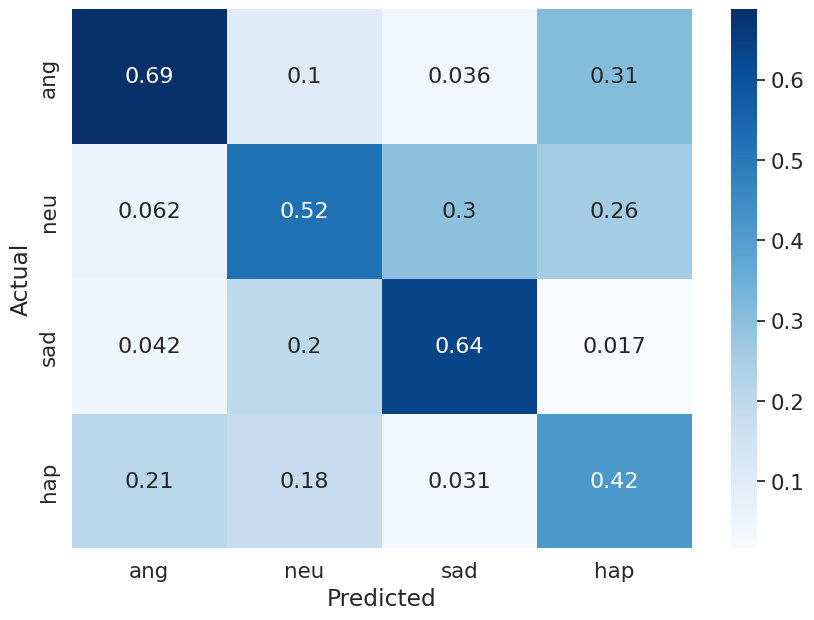

In [20]:
labels = dataset_config.target_labels
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

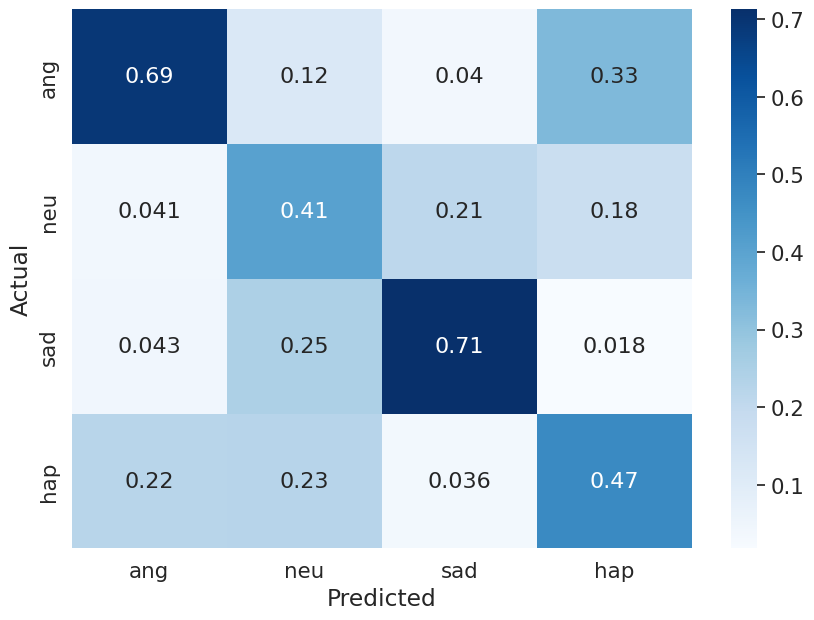

In [21]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [22]:
print(trainer.best_test_model_path)

../scb16_models/iemocap/run0/model.epoch=21.step=31080.test_acc=0.5516.pt


In [23]:
me = {'acc_unweighted': torch.tensor(0.5561),
 'acc_weighted': torch.tensor(0.5516),
 'f1s_unweighted': torch.tensor(0.5482),
 'f1s_weighted': torch.tensor(0.5465),
 'rocauc': torch.tensor(0.7992),
 'uar': torch.tensor(0.5561),
 'wap': torch.tensor(0.5483)}

med = {'acc_detail': torch.tensor([0.5611, 0.5088, 0.7604, 0.3942]),
 'f1s_detail': torch.tensor([0.5905, 0.5241, 0.6600, 0.4184]),
 'precision_detail': torch.tensor([0.6231, 0.5404, 0.5830, 0.4457]),
 'recall_detail': torch.tensor([0.5611, 0.5088, 0.7604, 0.3942]),
 'rocauc_detail': torch.tensor([0.8440, 0.7415, 0.8794, 0.7320])}

cm = torch.tensor([[124,  42,   9,  46],
        [ 19, 174,  97,  52],
        [  7,  41, 165,   4],
        [ 49,  65,  12,  82]])

<Axes: xlabel='Predicted', ylabel='Actual'>

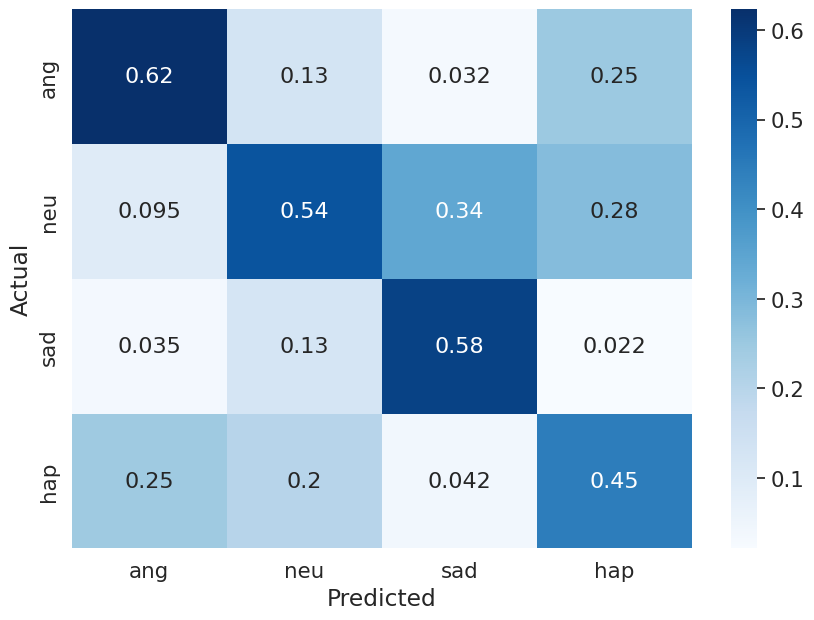

In [24]:
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

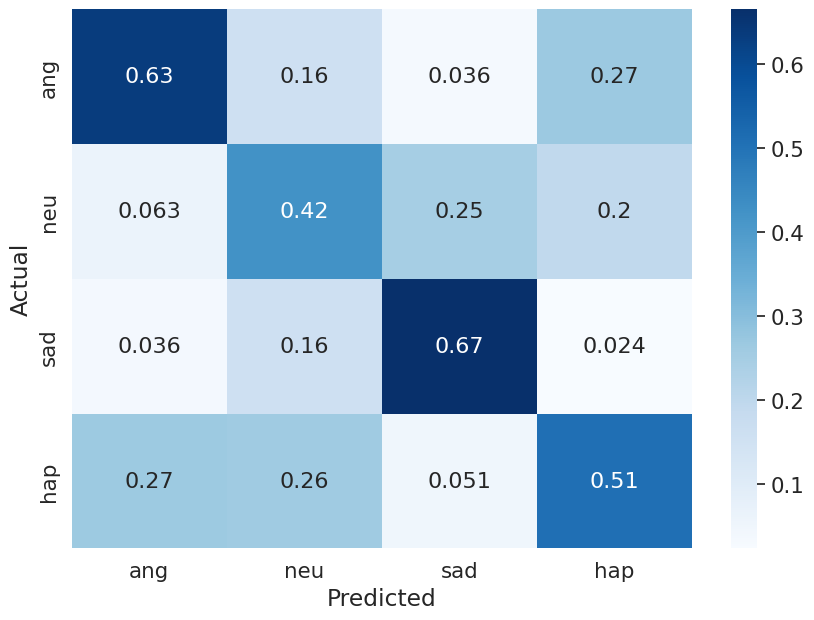

In [25]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [26]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

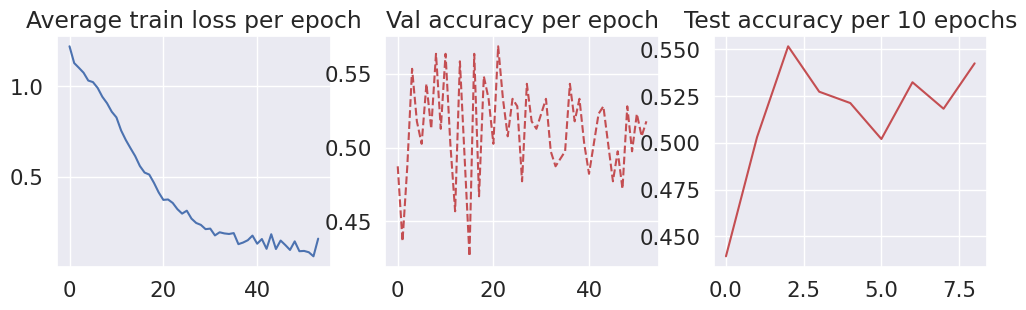

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

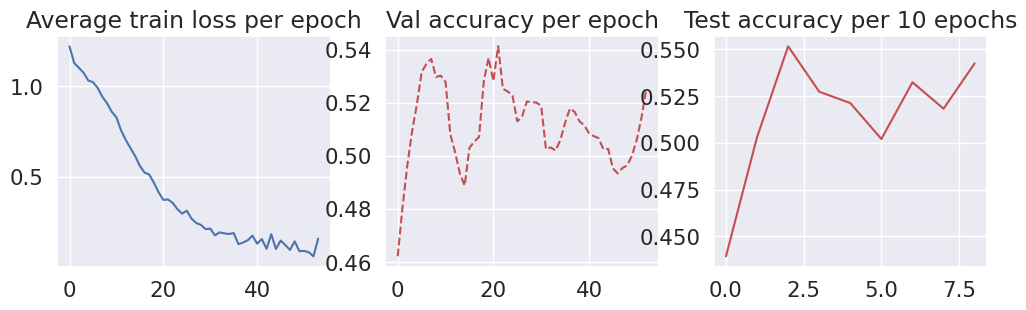

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

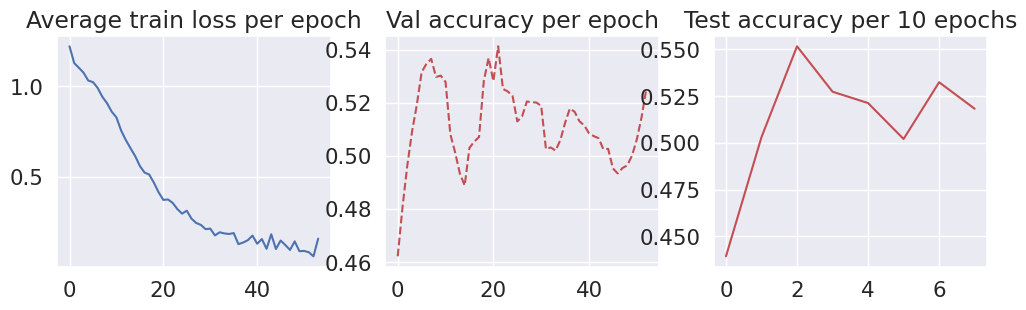

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy[:-1], color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [30]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model_path': trainer.best_test_model_path
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")

## run1

In [31]:
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run1/'
trainer.log_dir = log_dir

In [32]:
iconnet_config = ocf.load(iconnet_config_path)
iconnet_config.fe.n_channel = [456]
iconnet_config.fe.window_k = [2]
iconnet_config.cls = {'n_block': 1, 'n_hidden_dim': [512,], 'norm_type': 'LayerNorm'}
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [456], 'kernel_size': [511], 'stride': [2], 'window_k': [2], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 1, 'n_hidden_dim': [512], 'norm_type': 'LayerNorm'}}


In [33]:
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [34]:
trainer.setup(model=model, lr=learning_rate)

In [35]:
trainer.fit(n_epoch=30, self_supervised=False, train_task='embedding', test_n_epoch=10)

  2%|▊                                                   | 0.476833976833989/30 [09:16<285:15:48, 34784.51s/it]

Epoch: 1	Loss: 0.847 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.847]	Val_acc: 97/197 (49.24%)

Saved new best val model: ../scb16_models/iemocap/run1/model.epoch=1.step=741.loss=0.847.val_acc=0.492.pt


  5%|██▌                                                    | 1.4295366795367364/30 [24:12<6:31:10, 821.51s/it]

Correct: 488/988 (0.4939)
Saved new best test model: ../scb16_models/iemocap/run1/model.epoch=1.step=1480.test_acc=0.4939.pt
{'acc_unweighted': tensor(0.4854, device='cuda:0'),
 'acc_weighted': tensor(0.4939, device='cuda:0'),
 'f1s_unweighted': tensor(0.4637, device='cuda:0'),
 'f1s_weighted': tensor(0.4701, device='cuda:0'),
 'rocauc': tensor(0.7680, device='cuda:0'),
 'uar': tensor(0.4854, device='cuda:0'),
 'wap': tensor(0.4754, device='cuda:0')}
{'acc_detail': tensor([0.5385, 0.5263, 0.7373, 0.1394], device='cuda:0'),
 'f1s_detail': tensor([0.5497, 0.4932, 0.6119, 0.2000], device='cuda:0'),
 'precision_detail': tensor([0.5613, 0.4639, 0.5229, 0.3537], device='cuda:0'),
 'recall_detail': tensor([0.5385, 0.5263, 0.7373, 0.1394], device='cuda:0'),
 'rocauc_detail': tensor([0.8018, 0.6644, 0.8761, 0.7298], device='cuda:0')}
tensor([[119,  64,  17,  21],
        [ 15, 180, 116,  31],
        [  3,  53, 160,   1],
        [ 75,  91,  13,  29]], device='cuda:0')


  6%|███▏                                               | 1.9063706563707945/30 [35:29<404:15:54, 51803.72s/it]

Epoch: 2	Loss: 0.797 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.797]	Val_acc: 102/197 (51.78%)

Saved new best val model: ../scb16_models/iemocap/run1/model.epoch=2.step=2221.loss=0.797.val_acc=0.518.pt


 10%|████▋                                            | 2.8590733590736597/30 [1:01:59<371:58:28, 49339.07s/it]

Epoch: 3	Loss: 1.080 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.080]	Val_acc: 89/197 (45.18%)



 13%|██████▎                                           | 3.811776061776525/30 [1:25:05<256:14:08, 35223.78s/it]

Epoch: 4	Loss: 2.211 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.211]	Val_acc: 104/197 (52.79%)

Saved new best val model: ../scb16_models/iemocap/run1/model.epoch=4.step=5181.loss=2.211.val_acc=0.528.pt


 16%|████████                                           | 4.76447876447939/30 [1:42:44<246:24:35, 35151.86s/it]

Epoch: 5	Loss: 1.375 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.375]	Val_acc: 108/197 (54.82%)

Saved new best val model: ../scb16_models/iemocap/run1/model.epoch=5.step=6661.loss=1.375.val_acc=0.548.pt


 19%|█████████▌                                        | 5.717181467182255/30 [2:00:25<238:35:51, 35372.79s/it]

Epoch: 6	Loss: 0.900 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.900]	Val_acc: 102/197 (51.78%)



 22%|███████████▊                                         | 6.669401544402494/30 [2:17:16<7:13:14, 1114.16s/it]

Epoch: 7	Loss: 0.733 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.733]	Val_acc: 110/197 (55.84%)

Saved new best val model: ../scb16_models/iemocap/run1/model.epoch=7.step=9621.loss=0.733.val_acc=0.558.pt


 25%|████████████▋                                     | 7.622586872587985/30 [2:35:59<222:02:41, 35721.82s/it]

Epoch: 8	Loss: 0.912 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.912]	Val_acc: 101/197 (51.27%)



 29%|██████████████▌                                    | 8.57528957529085/30 [2:53:45<212:32:30, 35713.46s/it]

Epoch: 9	Loss: 0.730 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.730]	Val_acc: 107/197 (54.31%)



 32%|███████████████▉                                  | 9.527992277993715/30 [3:11:35<201:21:11, 35407.95s/it]

Epoch: 10	Loss: 0.061 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.061]	Val_acc: 94/197 (47.72%)



 35%|██████████████████▏                                 | 10.480212355213954/30 [3:28:26<6:21:15, 1171.90s/it]

Epoch: 11	Loss: 0.983 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.983]	Val_acc: 113/197 (57.36%)

Saved new best val model: ../scb16_models/iemocap/run1/model.epoch=11.step=15541.loss=0.983.val_acc=0.574.pt


 38%|████████████████████▏                                | 11.433397683399445/30 [3:44:03<3:59:52, 775.19s/it]

Correct: 580/988 (0.5870)
Saved new best test model: ../scb16_models/iemocap/run1/model.epoch=11.step=16280.test_acc=0.5870.pt
{'acc_unweighted': tensor(0.5644, device='cuda:0'),
 'acc_weighted': tensor(0.5870, device='cuda:0'),
 'f1s_unweighted': tensor(0.5717, device='cuda:0'),
 'f1s_weighted': tensor(0.5816, device='cuda:0'),
 'rocauc': tensor(0.8253, device='cuda:0'),
 'uar': tensor(0.5644, device='cuda:0'),
 'wap': tensor(0.6108, device='cuda:0')}
{'acc_detail': tensor([0.6787, 0.7281, 0.4470, 0.4038], device='cuda:0'),
 'f1s_detail': tensor([0.6369, 0.6376, 0.5826, 0.4297], device='cuda:0'),
 'precision_detail': tensor([0.6000, 0.5672, 0.8362, 0.4590], device='cuda:0'),
 'recall_detail': tensor([0.6787, 0.7281, 0.4470, 0.4038], device='cuda:0'),
 'rocauc_detail': tensor([0.8674, 0.7747, 0.9050, 0.7541], device='cuda:0')}
tensor([[150,  28,   2,  41],
        [ 32, 249,  13,  48],
        [  7, 103,  97,  10],
        [ 61,  59,   4,  84]], device='cuda:0')


 40%|███████████████████▍                             | 11.910231660233503/30 [3:53:27<179:27:49, 35714.65s/it]

Epoch: 12	Loss: 0.650 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.650]	Val_acc: 103/197 (52.28%)



 43%|█████████████████████                            | 12.862934362936368/30 [4:11:28<170:21:34, 35787.63s/it]

Epoch: 13	Loss: 0.166 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.166]	Val_acc: 117/197 (59.39%)

Saved new best val model: ../scb16_models/iemocap/run1/model.epoch=13.step=18501.loss=0.166.val_acc=0.594.pt


 46%|██████████████████████▌                          | 13.815637065639233/30 [4:29:26<161:25:17, 35906.08s/it]

Epoch: 14	Loss: 0.772 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.772]	Val_acc: 103/197 (52.28%)



 49%|████████████████████████                         | 14.768339768342098/30 [4:47:25<151:38:11, 35839.26s/it]

Epoch: 15	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 93/197 (47.21%)



 52%|█████████████████████████▋                       | 15.721042471044964/30 [5:05:31<143:15:00, 36116.09s/it]

Epoch: 16	Loss: 0.010 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.010]	Val_acc: 102/197 (51.78%)



 56%|███████████████████████████▊                      | 16.67374517374783/30 [5:23:32<133:21:12, 36024.58s/it]

Epoch: 17	Loss: 1.276 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.276]	Val_acc: 99/197 (50.25%)



 59%|████████████████████████████▊                    | 17.626447876450694/30 [5:41:44<123:33:02, 35946.21s/it]

Epoch: 18	Loss: 0.019 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.019]	Val_acc: 93/197 (47.21%)



 62%|██████████████████████████████▉                   | 18.57915057915356/30 [5:59:47<113:55:00, 35908.07s/it]

Epoch: 19	Loss: 0.242 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.242]	Val_acc: 100/197 (50.76%)



 65%|███████████████████████████████▉                 | 19.531853281856424/30 [6:17:56<104:57:41, 36096.31s/it]

Epoch: 20	Loss: 0.073 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.073]	Val_acc: 94/197 (47.72%)



 68%|██████████████████████████████████▊                | 20.48455598455929/30 [6:36:06<95:46:30, 36234.79s/it]

Epoch: 21	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 108/197 (54.82%)



 71%|█████████████████████████████████████▊               | 21.437258687262155/30 [6:51:12<1:54:06, 799.62s/it]

Correct: 549/988 (0.5557)
{'acc_unweighted': tensor(0.5492, device='cuda:0'),
 'acc_weighted': tensor(0.5557, device='cuda:0'),
 'f1s_unweighted': tensor(0.5492, device='cuda:0'),
 'f1s_weighted': tensor(0.5532, device='cuda:0'),
 'rocauc': tensor(0.8062, device='cuda:0'),
 'uar': tensor(0.5492, device='cuda:0'),
 'wap': tensor(0.5696, device='cuda:0')}
{'acc_detail': tensor([0.3891, 0.6053, 0.6590, 0.5433], device='cuda:0'),
 'f1s_detail': tensor([0.4900, 0.5782, 0.6384, 0.4902], device='cuda:0'),
 'precision_detail': tensor([0.6615, 0.5535, 0.6190, 0.4466], device='cuda:0'),
 'recall_detail': tensor([0.3891, 0.6053, 0.6590, 0.5433], device='cuda:0'),
 'rocauc_detail': tensor([0.8316, 0.7480, 0.8909, 0.7542], device='cuda:0')}
tensor([[ 86,  45,  13,  77],
        [ 16, 207,  69,  50],
        [  1,  60, 143,  13],
        [ 27,  62,   6, 113]], device='cuda:0')


 73%|████████████████████████████████████▌             | 21.914092664096213/30 [7:00:48<82:03:34, 36534.46s/it]

Epoch: 22	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 99/197 (50.25%)



 76%|██████████████████████████████████████            | 22.866795366799078/30 [7:18:59<72:01:23, 36348.77s/it]

Epoch: 23	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 90/197 (45.69%)



 79%|███████████████████████████████████████▋          | 23.819498069501943/30 [7:37:22<62:19:31, 36303.17s/it]

Epoch: 24	Loss: 0.649 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.649]	Val_acc: 96/197 (48.73%)



 83%|██████████████████████████████████████████         | 24.77220077220481/30 [7:55:38<53:15:48, 36678.58s/it]

Epoch: 25	Loss: 0.283 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.283]	Val_acc: 100/197 (50.76%)



 86%|██████████████████████████████████████████▊       | 25.724903474907673/30 [8:14:02<43:09:34, 36343.99s/it]

Epoch: 26	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 107/197 (54.31%)



 89%|█████████████████████████████████████████████▎     | 26.67760617761054/30 [8:32:25<33:54:04, 36733.94s/it]

Epoch: 27	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 100/197 (50.76%)



 92%|██████████████████████████████████████████████    | 27.630308880313404/30 [8:50:50<24:09:38, 36704.66s/it]

Epoch: 28	Loss: 0.410 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.410]	Val_acc: 94/197 (47.72%)



 95%|████████████████████████████████████████████████▌  | 28.58301158301627/30 [9:09:24<14:26:33, 36692.72s/it]

Epoch: 29	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 95/197 (48.22%)



 98%|██████████████████████████████████████████████████▏| 29.535714285719134/30 [9:27:57<4:46:01, 36962.29s/it]

Epoch: 30	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 96/197 (48.73%)



100%|█████████████████████████████████████████████████████▉| 29.999517374522302/30 [9:36:26<00:00, 1087.44s/it]/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████| 30.01158301158794/30 [9:36:41<-1:59:47, 1152.93s/it]


In [36]:
trainer.fit(n_epoch=30, self_supervised=False, train_task='embedding', test_n_epoch=1)

  1%|▌                                                  | 0.3335584064821085/30 [09:39<432:30:05, 52483.74s/it]

Epoch: 31	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 95/197 (48.22%)



  3%|█▊                                                    | 0.9999999999999617/30 [24:58<9:22:20, 1163.48s/it]

Correct: 538/988 (0.5445)
{'acc_unweighted': tensor(0.5493, device='cuda:0'),
 'acc_weighted': tensor(0.5445, device='cuda:0'),
 'f1s_unweighted': tensor(0.5336, device='cuda:0'),
 'f1s_weighted': tensor(0.5355, device='cuda:0'),
 'rocauc': tensor(0.7910, device='cuda:0'),
 'uar': tensor(0.5493, device='cuda:0'),
 'wap': tensor(0.5423, device='cuda:0')}
{'acc_detail': tensor([0.6787, 0.4912, 0.7005, 0.3269], device='cuda:0'),
 'f1s_detail': tensor([0.5964, 0.5359, 0.6191, 0.3831], device='cuda:0'),
 'precision_detail': tensor([0.5319, 0.5895, 0.5547, 0.4626], device='cuda:0'),
 'recall_detail': tensor([0.6787, 0.4912, 0.7005, 0.3269], device='cuda:0'),
 'rocauc_detail': tensor([0.8327, 0.7446, 0.8722, 0.7146], device='cuda:0')}
tensor([[150,  21,  16,  34],
        [ 48, 168,  88,  38],
        [ 12,  46, 152,   7],
        [ 72,  50,  18,  68]], device='cuda:0')


  4%|██▎                                                | 1.3335584064820347/30 [34:47<422:33:22, 53065.62s/it]

Epoch: 32	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 95/197 (48.22%)



  7%|███▌                                                  | 1.9999999999998606/30 [50:17<9:14:15, 1187.68s/it]

Correct: 534/988 (0.5405)
{'acc_unweighted': tensor(0.5534, device='cuda:0'),
 'acc_weighted': tensor(0.5405, device='cuda:0'),
 'f1s_unweighted': tensor(0.5376, device='cuda:0'),
 'f1s_weighted': tensor(0.5350, device='cuda:0'),
 'rocauc': tensor(0.7829, device='cuda:0'),
 'uar': tensor(0.5534, device='cuda:0'),
 'wap': tensor(0.5445, device='cuda:0')}
{'acc_detail': tensor([0.6652, 0.4357, 0.7235, 0.3894], device='cuda:0'),
 'f1s_detail': tensor([0.5787, 0.5051, 0.6724, 0.3942], device='cuda:0'),
 'precision_detail': tensor([0.5122, 0.6008, 0.6280, 0.3990], device='cuda:0'),
 'recall_detail': tensor([0.6652, 0.4357, 0.7235, 0.3894], device='cuda:0'),
 'rocauc_detail': tensor([0.8257, 0.7304, 0.8863, 0.6891], device='cuda:0')}
tensor([[147,  19,  11,  44],
        [ 58, 149,  69,  66],
        [ 11,  37, 157,  12],
        [ 71,  43,  13,  81]], device='cuda:0')


  8%|███▊                                             | 2.3335584064819335/30 [1:00:10<409:12:28, 53246.76s/it]

Epoch: 33	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 104/197 (52.79%)



 10%|█████▏                                              | 2.9999999999997593/30 [1:15:35<8:51:28, 1181.07s/it]

Correct: 515/988 (0.5213)
{'acc_unweighted': tensor(0.5562, device='cuda:0'),
 'acc_weighted': tensor(0.5213, device='cuda:0'),
 'f1s_unweighted': tensor(0.5114, device='cuda:0'),
 'f1s_weighted': tensor(0.4954, device='cuda:0'),
 'rocauc': tensor(0.7932, device='cuda:0'),
 'uar': tensor(0.5562, device='cuda:0'),
 'wap': tensor(0.5454, device='cuda:0')}
{'acc_detail': tensor([0.7511, 0.2632, 0.7972, 0.4135], device='cuda:0'),
 'f1s_detail': tensor([0.6137, 0.3742, 0.6492, 0.4086], device='cuda:0'),
 'precision_detail': tensor([0.5188, 0.6475, 0.5475, 0.4038], device='cuda:0'),
 'recall_detail': tensor([0.7511, 0.2632, 0.7972, 0.4135], device='cuda:0'),
 'rocauc_detail': tensor([0.8329, 0.7432, 0.8928, 0.7038], device='cuda:0')}
tensor([[166,  12,  11,  32],
        [ 62,  90, 112,  78],
        [ 17,  10, 173,  17],
        [ 75,  27,  20,  86]], device='cuda:0')


 11%|█████▌                                            | 3.333558406481832/30 [1:25:26<394:54:58, 53314.14s/it]

Epoch: 34	Loss: 0.057 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.057]	Val_acc: 103/197 (52.28%)



 13%|███████                                              | 3.999999999999658/30 [1:41:00<8:32:52, 1183.57s/it]

Correct: 516/988 (0.5223)
{'acc_unweighted': tensor(0.5109, device='cuda:0'),
 'acc_weighted': tensor(0.5223, device='cuda:0'),
 'f1s_unweighted': tensor(0.5152, device='cuda:0'),
 'f1s_weighted': tensor(0.5235, device='cuda:0'),
 'rocauc': tensor(0.7862, device='cuda:0'),
 'uar': tensor(0.5109, device='cuda:0'),
 'wap': tensor(0.5273, device='cuda:0')}
{'acc_detail': tensor([0.5158, 0.5936, 0.5207, 0.4135], device='cuda:0'),
 'f1s_detail': tensor([0.5327, 0.5718, 0.5608, 0.3954], device='cuda:0'),
 'precision_detail': tensor([0.5507, 0.5516, 0.6075, 0.3789], device='cuda:0'),
 'recall_detail': tensor([0.5158, 0.5936, 0.5207, 0.4135], device='cuda:0'),
 'rocauc_detail': tensor([0.8193, 0.7512, 0.8635, 0.7109], device='cuda:0')}
tensor([[114,  30,  10,  67],
        [ 31, 203,  50,  58],
        [  9,  79, 113,  16],
        [ 53,  56,  13,  86]], device='cuda:0')


 14%|███████▏                                          | 4.333558406481731/30 [1:50:58<382:28:29, 53646.29s/it]

Epoch: 35	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 101/197 (51.27%)



 17%|████████▊                                            | 4.999999999999557/30 [2:06:26<8:19:59, 1199.97s/it]

Correct: 541/988 (0.5476)
{'acc_unweighted': tensor(0.5631, device='cuda:0'),
 'acc_weighted': tensor(0.5476, device='cuda:0'),
 'f1s_unweighted': tensor(0.5327, device='cuda:0'),
 'f1s_weighted': tensor(0.5298, device='cuda:0'),
 'rocauc': tensor(0.8038, device='cuda:0'),
 'uar': tensor(0.5631, device='cuda:0'),
 'wap': tensor(0.5527, device='cuda:0')}
{'acc_detail': tensor([0.6923, 0.4181, 0.8341, 0.3077], device='cuda:0'),
 'f1s_detail': tensor([0.6000, 0.4965, 0.6546, 0.3798], device='cuda:0'),
 'precision_detail': tensor([0.5294, 0.6111, 0.5387, 0.4961], device='cuda:0'),
 'recall_detail': tensor([0.6923, 0.4181, 0.8341, 0.3077], device='cuda:0'),
 'rocauc_detail': tensor([0.8357, 0.7508, 0.8899, 0.7388], device='cuda:0')}
tensor([[153,  25,  17,  26],
        [ 54, 143, 111,  34],
        [ 10,  21, 181,   5],
        [ 72,  45,  27,  64]], device='cuda:0')


 18%|█████████                                          | 5.33355840648163/30 [2:16:17<364:09:30, 53147.95s/it]

Epoch: 36	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 93/197 (47.21%)



 20%|██████████▍                                         | 5.9999999999994555/30 [2:31:52<7:59:57, 1199.88s/it]

Correct: 524/988 (0.5304)
{'acc_unweighted': tensor(0.5276, device='cuda:0'),
 'acc_weighted': tensor(0.5304, device='cuda:0'),
 'f1s_unweighted': tensor(0.5250, device='cuda:0'),
 'f1s_weighted': tensor(0.5302, device='cuda:0'),
 'rocauc': tensor(0.7859, device='cuda:0'),
 'uar': tensor(0.5276, device='cuda:0'),
 'wap': tensor(0.5614, device='cuda:0')}
{'acc_detail': tensor([0.3394, 0.5585, 0.6452, 0.5673], device='cuda:0'),
 'f1s_detail': tensor([0.4478, 0.5634, 0.6393, 0.4495], device='cuda:0'),
 'precision_detail': tensor([0.6579, 0.5685, 0.6335, 0.3722], device='cuda:0'),
 'recall_detail': tensor([0.3394, 0.5585, 0.6452, 0.5673], device='cuda:0'),
 'rocauc_detail': tensor([0.8007, 0.7387, 0.8697, 0.7345], device='cuda:0')}
tensor([[ 75,  38,   9,  99],
        [ 15, 191,  59,  77],
        [  1,  53, 140,  23],
        [ 23,  54,  13, 118]], device='cuda:0')


 21%|██████████▎                                      | 6.3335584064815285/30 [2:41:46<351:12:14, 53423.10s/it]

Epoch: 37	Loss: 0.014 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.014]	Val_acc: 87/197 (44.16%)



 23%|████████████▎                                        | 6.999999999999354/30 [2:57:24<7:44:01, 1210.48s/it]

Correct: 522/988 (0.5283)
{'acc_unweighted': tensor(0.5463, device='cuda:0'),
 'acc_weighted': tensor(0.5283, device='cuda:0'),
 'f1s_unweighted': tensor(0.5320, device='cuda:0'),
 'f1s_weighted': tensor(0.5270, device='cuda:0'),
 'rocauc': tensor(0.7860, device='cuda:0'),
 'uar': tensor(0.5463, device='cuda:0'),
 'wap': tensor(0.5473, device='cuda:0')}
{'acc_detail': tensor([0.6290, 0.3977, 0.6728, 0.4856], device='cuda:0'),
 'f1s_detail': tensor([0.5697, 0.4831, 0.6518, 0.4235], device='cuda:0'),
 'precision_detail': tensor([0.5206, 0.6154, 0.6320, 0.3755], device='cuda:0'),
 'recall_detail': tensor([0.6290, 0.3977, 0.6728, 0.4856], device='cuda:0'),
 'rocauc_detail': tensor([0.8173, 0.7389, 0.8881, 0.6998], device='cuda:0')}
tensor([[139,  18,  11,  53],
        [ 51, 136,  62,  93],
        [ 14,  35, 146,  22],
        [ 63,  32,  12, 101]], device='cuda:0')


 24%|████████████▏                                     | 7.333558406481427/30 [3:07:22<338:15:07, 53722.92s/it]

Epoch: 38	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 90/197 (45.69%)



 27%|██████████████▏                                      | 7.999999999999253/30 [3:23:04<7:24:46, 1213.02s/it]

Correct: 524/988 (0.5304)
{'acc_unweighted': tensor(0.5008, device='cuda:0'),
 'acc_weighted': tensor(0.5304, device='cuda:0'),
 'f1s_unweighted': tensor(0.5101, device='cuda:0'),
 'f1s_weighted': tensor(0.5211, device='cuda:0'),
 'rocauc': tensor(0.7750, device='cuda:0'),
 'uar': tensor(0.5008, device='cuda:0'),
 'wap': tensor(0.5399, device='cuda:0')}
{'acc_detail': tensor([0.5068, 0.7222, 0.4424, 0.3317], device='cuda:0'),
 'f1s_detail': tensor([0.5463, 0.5874, 0.5147, 0.3920], device='cuda:0'),
 'precision_detail': tensor([0.5926, 0.4950, 0.6154, 0.4792], device='cuda:0'),
 'recall_detail': tensor([0.5068, 0.7222, 0.4424, 0.3317], device='cuda:0'),
 'rocauc_detail': tensor([0.8165, 0.7325, 0.8237, 0.7273], device='cuda:0')}
tensor([[112,  61,   9,  39],
        [ 27, 247,  40,  28],
        [  5, 108,  96,   8],
        [ 45,  83,  11,  69]], device='cuda:0')


 28%|█████████████▉                                    | 8.333558406482203/30 [3:33:06<325:36:12, 54100.81s/it]

Epoch: 39	Loss: 0.037 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.037]	Val_acc: 93/197 (47.21%)



 30%|███████████████▉                                     | 9.000000000001782/30 [3:48:41<7:10:20, 1229.55s/it]

Correct: 512/988 (0.5182)
{'acc_unweighted': tensor(0.5604, device='cuda:0'),
 'acc_weighted': tensor(0.5182, device='cuda:0'),
 'f1s_unweighted': tensor(0.5129, device='cuda:0'),
 'f1s_weighted': tensor(0.4921, device='cuda:0'),
 'rocauc': tensor(0.7903, device='cuda:0'),
 'uar': tensor(0.5604, device='cuda:0'),
 'wap': tensor(0.5781, device='cuda:0')}
{'acc_detail': tensor([0.6742, 0.2222, 0.7972, 0.5481], device='cuda:0'),
 'f1s_detail': tensor([0.5948, 0.3408, 0.6732, 0.4427], device='cuda:0'),
 'precision_detail': tensor([0.5321, 0.7308, 0.5825, 0.3713], device='cuda:0'),
 'recall_detail': tensor([0.6742, 0.2222, 0.7972, 0.5481], device='cuda:0'),
 'rocauc_detail': tensor([0.8266, 0.7447, 0.8959, 0.6939], device='cuda:0')}
tensor([[149,   9,  12,  51],
        [ 49,  76,  98, 119],
        [ 13,   8, 173,  23],
        [ 69,  11,  14, 114]], device='cuda:0')


 31%|███████████████▌                                  | 9.333558406484732/30 [3:58:40<309:25:42, 53901.01s/it]

Epoch: 40	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 93/197 (47.21%)



 33%|█████████████████▎                                  | 10.000000000004311/30 [4:14:26<6:44:02, 1212.11s/it]

Correct: 537/988 (0.5435)
{'acc_unweighted': tensor(0.5264, device='cuda:0'),
 'acc_weighted': tensor(0.5435, device='cuda:0'),
 'f1s_unweighted': tensor(0.5050, device='cuda:0'),
 'f1s_weighted': tensor(0.5161, device='cuda:0'),
 'rocauc': tensor(0.7834, device='cuda:0'),
 'uar': tensor(0.5264, device='cuda:0'),
 'wap': tensor(0.5421, device='cuda:0')}
{'acc_detail': tensor([0.6154, 0.6316, 0.7097, 0.1490], device='cuda:0'),
 'f1s_detail': tensor([0.5824, 0.5707, 0.6337, 0.2331], device='cuda:0'),
 'precision_detail': tensor([0.5528, 0.5205, 0.5725, 0.5345], device='cuda:0'),
 'recall_detail': tensor([0.6154, 0.6316, 0.7097, 0.1490], device='cuda:0'),
 'rocauc_detail': tensor([0.8286, 0.7152, 0.8604, 0.7295], device='cuda:0')}
tensor([[136,  60,  14,  11],
        [ 37, 216,  76,  13],
        [  3,  57, 154,   3],
        [ 70,  82,  25,  31]], device='cuda:0')


 34%|████████████████▉                                | 10.333558406487262/30 [4:24:25<294:49:08, 53967.49s/it]

Epoch: 41	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 92/197 (46.70%)



 37%|███████████████████▍                                 | 11.00000000000684/30 [4:40:13<6:25:23, 1217.04s/it]

Correct: 541/988 (0.5476)
{'acc_unweighted': tensor(0.5500, device='cuda:0'),
 'acc_weighted': tensor(0.5476, device='cuda:0'),
 'f1s_unweighted': tensor(0.5419, device='cuda:0'),
 'f1s_weighted': tensor(0.5452, device='cuda:0'),
 'rocauc': tensor(0.7904, device='cuda:0'),
 'uar': tensor(0.5500, device='cuda:0'),
 'wap': tensor(0.5564, device='cuda:0')}
{'acc_detail': tensor([0.4344, 0.5292, 0.7604, 0.4760], device='cuda:0'),
 'f1s_detail': tensor([0.5053, 0.5612, 0.6680, 0.4333], device='cuda:0'),
 'precision_detail': tensor([0.6038, 0.5974, 0.5957, 0.3976], device='cuda:0'),
 'recall_detail': tensor([0.4344, 0.5292, 0.7604, 0.4760], device='cuda:0'),
 'rocauc_detail': tensor([0.8062, 0.7424, 0.8857, 0.7271], device='cuda:0')}
tensor([[ 96,  30,  18,  77],
        [ 24, 181,  77,  60],
        [  3,  36, 165,  13],
        [ 36,  56,  17,  99]], device='cuda:0')


 38%|██████████████████▌                              | 11.333558406489791/30 [4:50:10<281:33:32, 54301.32s/it]

Epoch: 42	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 98/197 (49.75%)



 40%|█████████████████████▏                               | 12.00000000000937/30 [5:06:04<6:06:01, 1220.08s/it]

Correct: 504/988 (0.5101)
{'acc_unweighted': tensor(0.5159, device='cuda:0'),
 'acc_weighted': tensor(0.5101, device='cuda:0'),
 'f1s_unweighted': tensor(0.5109, device='cuda:0'),
 'f1s_weighted': tensor(0.5124, device='cuda:0'),
 'rocauc': tensor(0.7803, device='cuda:0'),
 'uar': tensor(0.5159, device='cuda:0'),
 'wap': tensor(0.5223, device='cuda:0')}
{'acc_detail': tensor([0.5249, 0.4649, 0.6267, 0.4471], device='cuda:0'),
 'f1s_detail': tensor([0.5498, 0.5129, 0.5837, 0.3974], device='cuda:0'),
 'precision_detail': tensor([0.5771, 0.5719, 0.5462, 0.3577], device='cuda:0'),
 'recall_detail': tensor([0.5249, 0.4649, 0.6267, 0.4471], device='cuda:0'),
 'rocauc_detail': tensor([0.8276, 0.7338, 0.8585, 0.7011], device='cuda:0')}
tensor([[116,  21,  18,  66],
        [ 30, 159,  74,  79],
        [  4,  55, 136,  22],
        [ 51,  43,  21,  93]], device='cuda:0')


 41%|████████████████████▌                             | 12.33355840649232/30 [5:16:09<265:42:20, 54144.50s/it]

Epoch: 43	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 84/197 (42.64%)



 43%|███████████████████████▍                              | 13.0000000000119/30 [5:31:58<5:49:26, 1233.33s/it]

Correct: 529/988 (0.5354)
{'acc_unweighted': tensor(0.5138, device='cuda:0'),
 'acc_weighted': tensor(0.5354, device='cuda:0'),
 'f1s_unweighted': tensor(0.5178, device='cuda:0'),
 'f1s_weighted': tensor(0.5278, device='cuda:0'),
 'rocauc': tensor(0.7815, device='cuda:0'),
 'uar': tensor(0.5138, device='cuda:0'),
 'wap': tensor(0.5428, device='cuda:0')}
{'acc_detail': tensor([0.6109, 0.6667, 0.4747, 0.3029], device='cuda:0'),
 'f1s_detail': tensor([0.5625, 0.5846, 0.5659, 0.3580], device='cuda:0'),
 'precision_detail': tensor([0.5212, 0.5205, 0.7007, 0.4375], device='cuda:0'),
 'recall_detail': tensor([0.6109, 0.6667, 0.4747, 0.3029], device='cuda:0'),
 'rocauc_detail': tensor([0.8171, 0.7372, 0.8676, 0.7042], device='cuda:0')}
tensor([[135,  43,   3,  40],
        [ 49, 228,  33,  32],
        [ 11,  94, 103,   9],
        [ 64,  73,   8,  63]], device='cuda:0')


 44%|███████████████████████▌                             | 13.33322079677169/30 [5:41:03<7:57:31, 1719.07s/it]

Epoch: 44	Loss: 0.036 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.036]	Val_acc: 96/197 (48.73%)



 47%|████████████████████████▋                            | 14.00000000001443/30 [5:57:56<5:24:57, 1218.61s/it]

Correct: 493/988 (0.4990)
{'acc_unweighted': tensor(0.5322, device='cuda:0'),
 'acc_weighted': tensor(0.4990, device='cuda:0'),
 'f1s_unweighted': tensor(0.4877, device='cuda:0'),
 'f1s_weighted': tensor(0.4745, device='cuda:0'),
 'rocauc': tensor(0.7905, device='cuda:0'),
 'uar': tensor(0.5322, device='cuda:0'),
 'wap': tensor(0.5373, device='cuda:0')}
{'acc_detail': tensor([0.5158, 0.2632, 0.9124, 0.4375], device='cuda:0'),
 'f1s_detail': tensor([0.5241, 0.3766, 0.6439, 0.4062], device='cuda:0'),
 'precision_detail': tensor([0.5327, 0.6618, 0.4975, 0.3792], device='cuda:0'),
 'recall_detail': tensor([0.5158, 0.2632, 0.9124, 0.4375], device='cuda:0'),
 'rocauc_detail': tensor([0.8157, 0.7216, 0.8974, 0.7274], device='cuda:0')}
tensor([[114,  13,  22,  72],
        [ 41,  90, 141,  70],
        [  6,   6, 198,   7],
        [ 53,  27,  37,  91]], device='cuda:0')


 48%|███████████████████████▉                          | 14.33355840649738/30 [6:07:59<236:31:27, 54351.03s/it]

Epoch: 45	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 91/197 (46.19%)



 50%|██████████████████████████                          | 15.000000000016959/30 [6:23:59<5:05:33, 1222.22s/it]

Correct: 515/988 (0.5213)
{'acc_unweighted': tensor(0.5266, device='cuda:0'),
 'acc_weighted': tensor(0.5213, device='cuda:0'),
 'f1s_unweighted': tensor(0.5222, device='cuda:0'),
 'f1s_weighted': tensor(0.5239, device='cuda:0'),
 'rocauc': tensor(0.7886, device='cuda:0'),
 'uar': tensor(0.5266, device='cuda:0'),
 'wap': tensor(0.5386, device='cuda:0')}
{'acc_detail': tensor([0.4615, 0.4854, 0.6452, 0.5144], device='cuda:0'),
 'f1s_detail': tensor([0.5165, 0.5295, 0.6114, 0.4315], device='cuda:0'),
 'precision_detail': tensor([0.5862, 0.5825, 0.5809, 0.3715], device='cuda:0'),
 'recall_detail': tensor([0.4615, 0.4854, 0.6452, 0.5144], device='cuda:0'),
 'rocauc_detail': tensor([0.8264, 0.7444, 0.8732, 0.7104], device='cuda:0')}
tensor([[102,  24,  14,  81],
        [ 26, 166,  73,  77],
        [  2,  52, 140,  23],
        [ 44,  43,  14, 107]], device='cuda:0')


 51%|█████████████████████████▌                        | 15.33355840649991/30 [6:34:08<223:09:08, 54774.59s/it]

Epoch: 46	Loss: 0.113 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.113]	Val_acc: 109/197 (55.33%)



 53%|███████████████████████████▋                        | 16.000000000019487/30 [6:50:06<4:46:24, 1227.44s/it]

Correct: 537/988 (0.5435)
{'acc_unweighted': tensor(0.5596, device='cuda:0'),
 'acc_weighted': tensor(0.5435, device='cuda:0'),
 'f1s_unweighted': tensor(0.5407, device='cuda:0'),
 'f1s_weighted': tensor(0.5370, device='cuda:0'),
 'rocauc': tensor(0.7993, device='cuda:0'),
 'uar': tensor(0.5596, device='cuda:0'),
 'wap': tensor(0.5517, device='cuda:0')}
{'acc_detail': tensor([0.5747, 0.4240, 0.7926, 0.4471], device='cuda:0'),
 'f1s_detail': tensor([0.5708, 0.5026, 0.6577, 0.4316], device='cuda:0'),
 'precision_detail': tensor([0.5670, 0.6170, 0.5621, 0.4170], device='cuda:0'),
 'recall_detail': tensor([0.5747, 0.4240, 0.7926, 0.4471], device='cuda:0'),
 'rocauc_detail': tensor([0.8272, 0.7535, 0.8950, 0.7213], device='cuda:0')}
tensor([[127,  22,  17,  55],
        [ 36, 145, 101,  60],
        [  6,  24, 172,  15],
        [ 55,  44,  16,  93]], device='cuda:0')


 54%|██████████████████████████▋                      | 16.333558406502437/30 [7:00:17<208:23:59, 54896.51s/it]

Epoch: 47	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 89/197 (45.18%)



 57%|█████████████████████████████▍                      | 17.000000000022016/30 [7:16:18<4:29:43, 1244.89s/it]

Correct: 549/988 (0.5557)
{'acc_unweighted': tensor(0.5466, device='cuda:0'),
 'acc_weighted': tensor(0.5557, device='cuda:0'),
 'f1s_unweighted': tensor(0.5441, device='cuda:0'),
 'f1s_weighted': tensor(0.5498, device='cuda:0'),
 'rocauc': tensor(0.7936, device='cuda:0'),
 'uar': tensor(0.5466, device='cuda:0'),
 'wap': tensor(0.5523, device='cuda:0')}
{'acc_detail': tensor([0.5113, 0.6053, 0.7189, 0.3510], device='cuda:0'),
 'f1s_detail': tensor([0.5636, 0.5774, 0.6460, 0.3893], device='cuda:0'),
 'precision_detail': tensor([0.6278, 0.5520, 0.5865, 0.4371], device='cuda:0'),
 'recall_detail': tensor([0.5113, 0.6053, 0.7189, 0.3510], device='cuda:0'),
 'rocauc_detail': tensor([0.8319, 0.7328, 0.8779, 0.7318], device='cuda:0')}
tensor([[113,  42,  16,  50],
        [ 22, 207,  76,  37],
        [  3,  51, 156,   7],
        [ 42,  75,  18,  73]], device='cuda:0')


 58%|████████████████████████████▎                    | 17.333558406504967/30 [7:26:28<192:52:36, 54818.57s/it]

Epoch: 48	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 95/197 (48.22%)



 60%|███████████████████████████████▏                    | 18.000000000024546/30 [7:42:30<4:06:08, 1230.67s/it]

Correct: 493/988 (0.4990)
{'acc_unweighted': tensor(0.5293, device='cuda:0'),
 'acc_weighted': tensor(0.4990, device='cuda:0'),
 'f1s_unweighted': tensor(0.5073, device='cuda:0'),
 'f1s_weighted': tensor(0.4955, device='cuda:0'),
 'rocauc': tensor(0.7857, device='cuda:0'),
 'uar': tensor(0.5293, device='cuda:0'),
 'wap': tensor(0.5580, device='cuda:0')}
{'acc_detail': tensor([0.5747, 0.2953, 0.6175, 0.6298], device='cuda:0'),
 'f1s_detail': tensor([0.5619, 0.4073, 0.6204, 0.4396], device='cuda:0'),
 'precision_detail': tensor([0.5498, 0.6558, 0.6233, 0.3376], device='cuda:0'),
 'recall_detail': tensor([0.5747, 0.2953, 0.6175, 0.6298], device='cuda:0'),
 'rocauc_detail': tensor([0.8173, 0.7413, 0.8778, 0.7065], device='cuda:0')}
tensor([[127,   5,  10,  79],
        [ 45, 101,  64, 132],
        [  7,  30, 134,  46],
        [ 52,  18,   7, 131]], device='cuda:0')


 61%|█████████████████████████████▉                   | 18.333558406507496/30 [7:52:43<176:58:35, 54610.97s/it]

Epoch: 49	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 99/197 (50.25%)



 63%|████████████████████████████████▉                   | 19.000000000027075/30 [8:08:46<3:47:48, 1242.57s/it]

Correct: 543/988 (0.5496)
{'acc_unweighted': tensor(0.5575, device='cuda:0'),
 'acc_weighted': tensor(0.5496, device='cuda:0'),
 'f1s_unweighted': tensor(0.5440, device='cuda:0'),
 'f1s_weighted': tensor(0.5434, device='cuda:0'),
 'rocauc': tensor(0.8002, device='cuda:0'),
 'uar': tensor(0.5575, device='cuda:0'),
 'wap': tensor(0.5463, device='cuda:0')}
{'acc_detail': tensor([0.6244, 0.4795, 0.7558, 0.3702], device='cuda:0'),
 'f1s_detail': tensor([0.6066, 0.5256, 0.6560, 0.3879], device='cuda:0'),
 'precision_detail': tensor([0.5897, 0.5816, 0.5795, 0.4074], device='cuda:0'),
 'recall_detail': tensor([0.6244, 0.4795, 0.7558, 0.3702], device='cuda:0'),
 'rocauc_detail': tensor([0.8440, 0.7499, 0.8936, 0.7132], device='cuda:0')}
tensor([[138,  29,  14,  40],
        [ 34, 164,  85,  59],
        [  3,  37, 164,  13],
        [ 59,  52,  20,  77]], device='cuda:0')


 64%|███████████████████████████████▌                 | 19.333558406510026/30 [8:18:56<162:45:27, 54931.89s/it]

Epoch: 50	Loss: 0.011 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.011]	Val_acc: 103/197 (52.28%)



 67%|██████████████████████████████████▋                 | 20.000000000029605/30 [8:35:05<3:25:49, 1234.91s/it]

Correct: 530/988 (0.5364)
{'acc_unweighted': tensor(0.5623, device='cuda:0'),
 'acc_weighted': tensor(0.5364, device='cuda:0'),
 'f1s_unweighted': tensor(0.5293, device='cuda:0'),
 'f1s_weighted': tensor(0.5194, device='cuda:0'),
 'rocauc': tensor(0.8032, device='cuda:0'),
 'uar': tensor(0.5623, device='cuda:0'),
 'wap': tensor(0.5489, device='cuda:0')}
{'acc_detail': tensor([0.6290, 0.3450, 0.8618, 0.4135], device='cuda:0'),
 'f1s_detail': tensor([0.5940, 0.4419, 0.6459, 0.4354], device='cuda:0'),
 'precision_detail': tensor([0.5628, 0.6146, 0.5166, 0.4599], device='cuda:0'),
 'recall_detail': tensor([0.6290, 0.3450, 0.8618, 0.4135], device='cuda:0'),
 'rocauc_detail': tensor([0.8406, 0.7411, 0.8889, 0.7423], device='cuda:0')}
tensor([[139,  16,  21,  45],
        [ 47, 118, 126,  51],
        [  7,  18, 187,   5],
        [ 54,  40,  28,  86]], device='cuda:0')


 68%|█████████████████████████████████▏               | 20.333558406512555/30 [8:45:17<148:23:26, 55264.07s/it]

Epoch: 51	Loss: 5.351 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=5.351]	Val_acc: 89/197 (45.18%)



 70%|████████████████████████████████████▍               | 21.000000000032134/30 [9:01:29<3:08:28, 1256.52s/it]

Correct: 531/988 (0.5374)
{'acc_unweighted': tensor(0.5347, device='cuda:0'),
 'acc_weighted': tensor(0.5374, device='cuda:0'),
 'f1s_unweighted': tensor(0.5372, device='cuda:0'),
 'f1s_weighted': tensor(0.5417, device='cuda:0'),
 'rocauc': tensor(0.7902, device='cuda:0'),
 'uar': tensor(0.5347, device='cuda:0'),
 'wap': tensor(0.5639, device='cuda:0')}
{'acc_detail': tensor([0.4163, 0.5585, 0.6498, 0.5144], device='cuda:0'),
 'f1s_detail': tensor([0.5097, 0.5651, 0.6513, 0.4229], device='cuda:0'),
 'precision_detail': tensor([0.6571, 0.5719, 0.6528, 0.3591], device='cuda:0'),
 'recall_detail': tensor([0.4163, 0.5585, 0.6498, 0.5144], device='cuda:0'),
 'rocauc_detail': tensor([0.8303, 0.7475, 0.8695, 0.7133], device='cuda:0')}
tensor([[ 92,  31,   7,  91],
        [ 16, 191,  56,  79],
        [  3,  52, 141,  21],
        [ 29,  60,  12, 107]], device='cuda:0')


 71%|██████████████████████████████████▊              | 21.333558406515085/30 [9:11:47<133:19:01, 55379.27s/it]

Epoch: 52	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 97/197 (49.24%)



 73%|██████████████████████████████████████▏             | 22.000000000034664/30 [9:27:58<2:48:20, 1262.55s/it]

Correct: 522/988 (0.5283)
{'acc_unweighted': tensor(0.5484, device='cuda:0'),
 'acc_weighted': tensor(0.5283, device='cuda:0'),
 'f1s_unweighted': tensor(0.5246, device='cuda:0'),
 'f1s_weighted': tensor(0.5199, device='cuda:0'),
 'rocauc': tensor(0.8004, device='cuda:0'),
 'uar': tensor(0.5484, device='cuda:0'),
 'wap': tensor(0.5559, device='cuda:0')}
{'acc_detail': tensor([0.5249, 0.3830, 0.8387, 0.4471], device='cuda:0'),
 'f1s_detail': tensor([0.5757, 0.4781, 0.6201, 0.4247], device='cuda:0'),
 'precision_detail': tensor([0.6374, 0.6359, 0.4919, 0.4043], device='cuda:0'),
 'recall_detail': tensor([0.5249, 0.3830, 0.8387, 0.4471], device='cuda:0'),
 'rocauc_detail': tensor([0.8456, 0.7451, 0.8788, 0.7320], device='cuda:0')}
tensor([[116,  11,  31,  63],
        [ 25, 131, 122,  64],
        [  0,  25, 182,  10],
        [ 41,  39,  35,  93]], device='cuda:0')


 74%|████████████████████████████████████▍            | 22.333558406517614/30 [9:38:14<118:02:37, 55430.90s/it]

Epoch: 53	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 97/197 (49.24%)



 77%|███████████████████████████████████████▊            | 23.000000000037193/30 [9:54:29<2:25:44, 1249.16s/it]

Correct: 528/988 (0.5344)
{'acc_unweighted': tensor(0.5538, device='cuda:0'),
 'acc_weighted': tensor(0.5344, device='cuda:0'),
 'f1s_unweighted': tensor(0.5301, device='cuda:0'),
 'f1s_weighted': tensor(0.5247, device='cuda:0'),
 'rocauc': tensor(0.7993, device='cuda:0'),
 'uar': tensor(0.5538, device='cuda:0'),
 'wap': tensor(0.5473, device='cuda:0')}
{'acc_detail': tensor([0.5566, 0.3918, 0.8295, 0.4375], device='cuda:0'),
 'f1s_detail': tensor([0.5708, 0.4786, 0.6429, 0.4282], device='cuda:0'),
 'precision_detail': tensor([0.5857, 0.6147, 0.5248, 0.4194], device='cuda:0'),
 'recall_detail': tensor([0.5566, 0.3918, 0.8295, 0.4375], device='cuda:0'),
 'rocauc_detail': tensor([0.8337, 0.7479, 0.8917, 0.7239], device='cuda:0')}
tensor([[123,  23,  20,  55],
        [ 29, 134, 119,  60],
        [  6,  20, 180,  11],
        [ 52,  41,  24,  91]], device='cuda:0')


 78%|█████████████████████████████████████▎          | 23.333558406520144/30 [10:04:47<102:57:54, 55603.06s/it]

Epoch: 54	Loss: 0.997 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.997]	Val_acc: 99/197 (50.25%)



 80%|████████████████████████████████████████▊          | 24.000000000039723/30 [10:21:06<2:07:24, 1274.12s/it]

Correct: 520/988 (0.5263)
{'acc_unweighted': tensor(0.5361, device='cuda:0'),
 'acc_weighted': tensor(0.5263, device='cuda:0'),
 'f1s_unweighted': tensor(0.5149, device='cuda:0'),
 'f1s_weighted': tensor(0.5156, device='cuda:0'),
 'rocauc': tensor(0.7879, device='cuda:0'),
 'uar': tensor(0.5361, device='cuda:0'),
 'wap': tensor(0.5253, device='cuda:0')}
{'acc_detail': tensor([0.6968, 0.4357, 0.7235, 0.2885], device='cuda:0'),
 'f1s_detail': tensor([0.5822, 0.5042, 0.6542, 0.3191], device='cuda:0'),
 'precision_detail': tensor([0.5000, 0.5984, 0.5970, 0.3571], device='cuda:0'),
 'recall_detail': tensor([0.6968, 0.4357, 0.7235, 0.2885], device='cuda:0'),
 'rocauc_detail': tensor([0.8299, 0.7462, 0.8866, 0.6888], device='cuda:0')}
tensor([[154,  20,  11,  36],
        [ 48, 149,  81,  64],
        [ 15,  37, 157,   8],
        [ 91,  43,  14,  60]], device='cuda:0')


 81%|█████████████████████████████████████████▎         | 24.333220796799512/30 [10:30:22<2:39:40, 1690.69s/it]

Epoch: 55	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 102/197 (51.78%)



 83%|██████████████████████████████████████████▌        | 25.000000000042252/30 [10:47:46<1:45:24, 1265.00s/it]

Correct: 524/988 (0.5304)
{'acc_unweighted': tensor(0.5430, device='cuda:0'),
 'acc_weighted': tensor(0.5304, device='cuda:0'),
 'f1s_unweighted': tensor(0.5275, device='cuda:0'),
 'f1s_weighted': tensor(0.5253, device='cuda:0'),
 'rocauc': tensor(0.7964, device='cuda:0'),
 'uar': tensor(0.5430, device='cuda:0'),
 'wap': tensor(0.5344, device='cuda:0')}
{'acc_detail': tensor([0.6199, 0.4298, 0.7281, 0.3942], device='cuda:0'),
 'f1s_detail': tensor([0.5855, 0.4983, 0.6384, 0.3877], device='cuda:0'),
 'precision_detail': tensor([0.5547, 0.5927, 0.5683, 0.3814], device='cuda:0'),
 'recall_detail': tensor([0.6199, 0.4298, 0.7281, 0.3942], device='cuda:0'),
 'rocauc_detail': tensor([0.8328, 0.7530, 0.8848, 0.7151], device='cuda:0')}
tensor([[137,  21,  15,  48],
        [ 34, 147,  87,  74],
        [  6,  42, 158,  11],
        [ 70,  38,  18,  82]], device='cuda:0')


 84%|█████████████████████████████████████████▍       | 25.333558406525203/30 [10:58:06<72:34:53, 55994.17s/it]

Epoch: 56	Loss: 0.270 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.270]	Val_acc: 95/197 (48.22%)



 87%|████████████████████████████████████████████▏      | 26.000000000044782/30 [11:14:32<1:25:01, 1275.30s/it]

Correct: 532/988 (0.5385)
{'acc_unweighted': tensor(0.5367, device='cuda:0'),
 'acc_weighted': tensor(0.5385, device='cuda:0'),
 'f1s_unweighted': tensor(0.5364, device='cuda:0'),
 'f1s_weighted': tensor(0.5393, device='cuda:0'),
 'rocauc': tensor(0.7969, device='cuda:0'),
 'uar': tensor(0.5367, device='cuda:0'),
 'wap': tensor(0.5437, device='cuda:0')}
{'acc_detail': tensor([0.5023, 0.5439, 0.6774, 0.4231], device='cuda:0'),
 'f1s_detail': tensor([0.5522, 0.5487, 0.6447, 0.4000], device='cuda:0'),
 'precision_detail': tensor([0.6133, 0.5536, 0.6151, 0.3793], device='cuda:0'),
 'recall_detail': tensor([0.5023, 0.5439, 0.6774, 0.4231], device='cuda:0'),
 'rocauc_detail': tensor([0.8243, 0.7487, 0.8857, 0.7289], device='cuda:0')}
tensor([[111,  35,  10,  65],
        [ 23, 186,  67,  66],
        [  3,  54, 147,  13],
        [ 44,  61,  15,  88]], device='cuda:0')


 88%|███████████████████████████████████████████      | 26.333558406527732/30 [11:24:51<57:16:27, 56236.39s/it]

Epoch: 57	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 94/197 (47.72%)



 90%|██████████████████████████████████████████████▊     | 27.00000000004731/30 [11:41:21<1:04:13, 1284.62s/it]

Correct: 453/988 (0.4585)
{'acc_unweighted': tensor(0.4998, device='cuda:0'),
 'acc_weighted': tensor(0.4585, device='cuda:0'),
 'f1s_unweighted': tensor(0.4684, device='cuda:0'),
 'f1s_weighted': tensor(0.4458, device='cuda:0'),
 'rocauc': tensor(0.7670, device='cuda:0'),
 'uar': tensor(0.4998, device='cuda:0'),
 'wap': tensor(0.5435, device='cuda:0')}
{'acc_detail': tensor([0.5656, 0.1842, 0.5714, 0.6779], device='cuda:0'),
 'f1s_detail': tensor([0.5708, 0.2825, 0.6078, 0.4123], device='cuda:0'),
 'precision_detail': tensor([0.5760, 0.6058, 0.6492, 0.2962], device='cuda:0'),
 'recall_detail': tensor([0.5656, 0.1842, 0.5714, 0.6779], device='cuda:0'),
 'rocauc_detail': tensor([0.8063, 0.7130, 0.8824, 0.6661], device='cuda:0')}
tensor([[125,   6,   9,  81],
        [ 39,  63,  49, 191],
        [  4,  26, 124,  63],
        [ 49,   9,   9, 141]], device='cuda:0')


 91%|████████████████████████████████████████████▋    | 27.333558406530262/30 [11:51:51<41:36:28, 56175.33s/it]

Epoch: 58	Loss: 0.011 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.011]	Val_acc: 97/197 (49.24%)



 93%|██████████████████████████████████████████████████▍   | 28.00000000004984/30 [12:08:14<42:40, 1280.43s/it]

Correct: 525/988 (0.5314)
{'acc_unweighted': tensor(0.5543, device='cuda:0'),
 'acc_weighted': tensor(0.5314, device='cuda:0'),
 'f1s_unweighted': tensor(0.5108, device='cuda:0'),
 'f1s_weighted': tensor(0.5053, device='cuda:0'),
 'rocauc': tensor(0.7839, device='cuda:0'),
 'uar': tensor(0.5543, device='cuda:0'),
 'wap': tensor(0.5475, device='cuda:0')}
{'acc_detail': tensor([0.7195, 0.3480, 0.8756, 0.2740], device='cuda:0'),
 'f1s_detail': tensor([0.6139, 0.4516, 0.6365, 0.3413], device='cuda:0'),
 'precision_detail': tensor([0.5354, 0.6432, 0.5000, 0.4524], device='cuda:0'),
 'recall_detail': tensor([0.7195, 0.3480, 0.8756, 0.2740], device='cuda:0'),
 'rocauc_detail': tensor([0.8309, 0.7313, 0.8760, 0.6974], device='cuda:0')}
tensor([[159,  20,  20,  22],
        [ 48, 119, 132,  43],
        [ 12,  11, 190,   4],
        [ 78,  35,  38,  57]], device='cuda:0')


 94%|██████████████████████████████████████████████████▉   | 28.33322079680963/30 [12:17:38<49:43, 1789.75s/it]

Epoch: 59	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 98/197 (49.75%)



 97%|████████████████████████████████████████████████████▏ | 29.00000000005237/30 [12:35:11<21:35, 1295.49s/it]

Correct: 509/988 (0.5152)
{'acc_unweighted': tensor(0.5395, device='cuda:0'),
 'acc_weighted': tensor(0.5152, device='cuda:0'),
 'f1s_unweighted': tensor(0.4899, device='cuda:0'),
 'f1s_weighted': tensor(0.4841, device='cuda:0'),
 'rocauc': tensor(0.7813, device='cuda:0'),
 'uar': tensor(0.5395, device='cuda:0'),
 'wap': tensor(0.5276, device='cuda:0')}
{'acc_detail': tensor([0.8054, 0.3158, 0.8157, 0.2212], device='cuda:0'),
 'f1s_detail': tensor([0.5943, 0.4244, 0.6705, 0.2706], device='cuda:0'),
 'precision_detail': tensor([0.4709, 0.6467, 0.5691, 0.3485], device='cuda:0'),
 'recall_detail': tensor([0.8054, 0.3158, 0.8157, 0.2212], device='cuda:0'),
 'rocauc_detail': tensor([0.8363, 0.7326, 0.8892, 0.6669], device='cuda:0')}
tensor([[178,  10,  12,  21],
        [ 79, 108,  96,  59],
        [ 16,  18, 177,   6],
        [105,  31,  26,  46]], device='cuda:0')


 98%|████████████████████████████████████████████████▉ | 29.33355840653532/30 [12:45:35<10:25:10, 56284.36s/it]

Epoch: 60	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 92/197 (46.70%)



100%|███████████████████████████████████████████████████████| 30.0000000000549/30 [13:02:11<00:00, 1564.37s/it]

Correct: 512/988 (0.5182)
{'acc_unweighted': tensor(0.5293, device='cuda:0'),
 'acc_weighted': tensor(0.5182, device='cuda:0'),
 'f1s_unweighted': tensor(0.5041, device='cuda:0'),
 'f1s_weighted': tensor(0.5053, device='cuda:0'),
 'rocauc': tensor(0.7899, device='cuda:0'),
 'uar': tensor(0.5293, device='cuda:0'),
 'wap': tensor(0.5313, device='cuda:0')}
{'acc_detail': tensor([0.3982, 0.4357, 0.8940, 0.3894], device='cuda:0'),
 'f1s_detail': tensor([0.4706, 0.5059, 0.6532, 0.3866], device='cuda:0'),
 'precision_detail': tensor([0.5752, 0.6032, 0.5146, 0.3839], device='cuda:0'),
 'recall_detail': tensor([0.3982, 0.4357, 0.8940, 0.3894], device='cuda:0'),
 'rocauc_detail': tensor([0.8241, 0.7229, 0.8856, 0.7271], device='cuda:0')}
tensor([[ 88,  31,  30,  72],
        [ 25, 149, 117,  51],
        [  1,  15, 194,   7],
        [ 39,  52,  36,  81]], device='cuda:0')


In [37]:
trainer.load_best_model(val_model=True)

Loaded: ../scb16_models/iemocap/run1/model.epoch=13.step=18501.loss=0.166.val_acc=0.594.pt


In [38]:
metrics, metrics_details, confusion_matrix = trainer.test_step()

Correct: 575/988 (0.5820)


In [39]:
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.5687),
 'acc_weighted': tensor(0.5820),
 'f1s_unweighted': tensor(0.5667),
 'f1s_weighted': tensor(0.5741),
 'rocauc': tensor(0.8240),
 'uar': tensor(0.5687),
 'wap': tensor(0.5764)}
{'acc_detail': tensor([0.6154, 0.6550, 0.6728, 0.3317]),
 'f1s_detail': tensor([0.6196, 0.6112, 0.6362, 0.4000]),
 'precision_detail': tensor([0.6239, 0.5729, 0.6033, 0.5036]),
 'recall_detail': tensor([0.6154, 0.6550, 0.6728, 0.3317]),
 'rocauc_detail': tensor([0.8622, 0.7776, 0.8925, 0.7635])}
tensor([[136,  34,  15,  36],
        [ 24, 224,  68,  26],
        [  6,  59, 146,   6],
        [ 52,  74,  13,  69]])


<Axes: xlabel='Predicted', ylabel='Actual'>

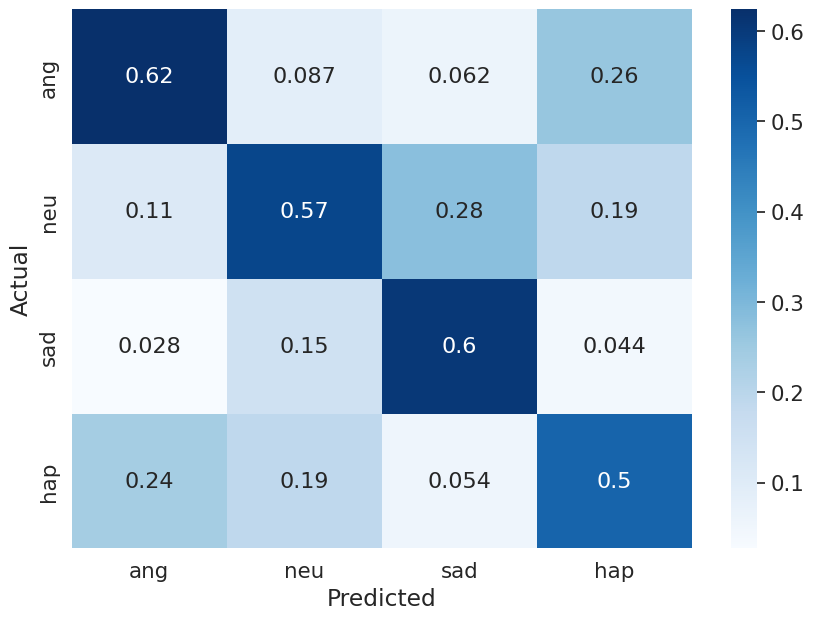

In [40]:
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

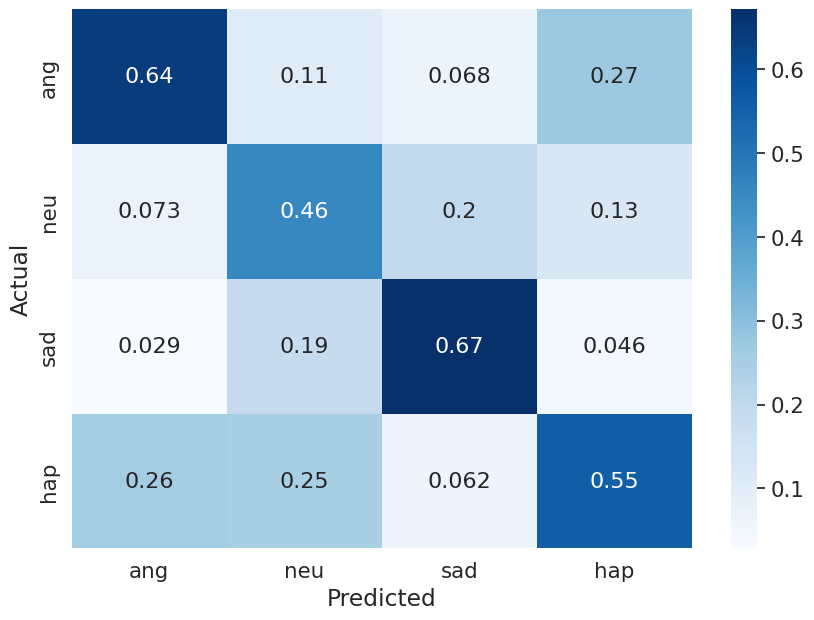

In [41]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [42]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

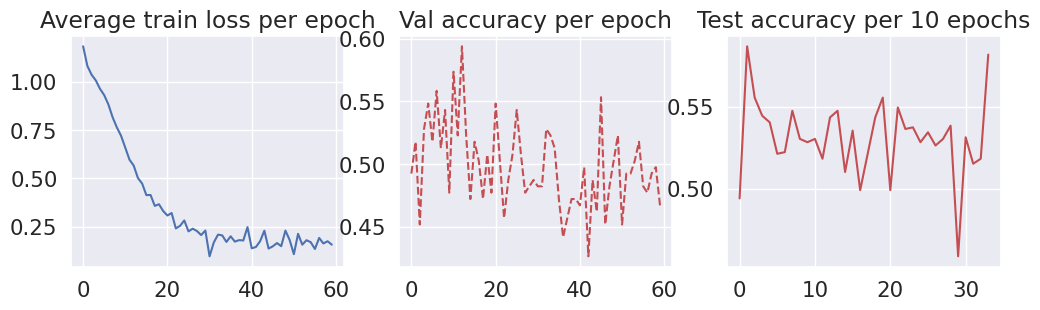

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

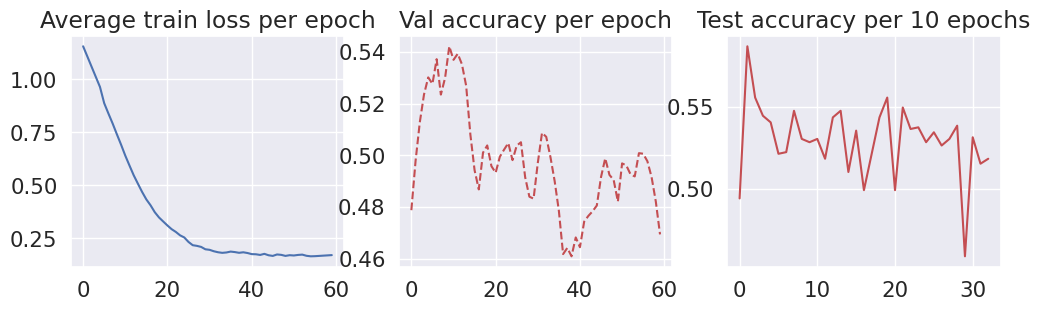

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(savgol_filter(train_losses, 10, 1), color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy[:-1], color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [45]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model_path': trainer.best_val_model_path
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")